In [3]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK
from hyperopt.early_stop import no_progress_loss
import xgboost as xgb
import shap

import warnings
warnings.filterwarnings('ignore')

plt.style.use("ggplot")

### Preprocessamento

##### Background

In [69]:
adata = sc.read_h5ad("../date/omics_data/rna_seq_total_magic") # MAGIC + log1p
trasc_df = adata.to_df()

# Elimina pseudogeni
pseduo_genes = pd.read_csv("../date/Info/pseudogene.txt", sep="\t")
pseduo_genes = pseduo_genes["Gene stable ID"].tolist()
trasc_df = trasc_df.drop(columns=pseduo_genes, errors='ignore')

# Elimina geni metabolici
metabolic_genes = pd.read_csv("../date/Info/protein_class_Metabolic.tsv", sep="\t", index_col=0)
gene_info = pd.read_csv("../date/Info/gene_info.csv")
gene_info.set_index("gene_name", inplace=True)
metabolic_genes = metabolic_genes.merge(gene_info, left_index=True, right_index=True)
trasc_df.drop(columns=metabolic_genes["gene_id"], errors='ignore', inplace=True)
len(trasc_df.columns)

32555

Save background 

In [ ]:
background_genes = []
for gene in trasc_df.columns:
    background_genes.append(gene)
len(background_genes)

In [ ]:
# Save background genes 
background_genes = trasc_df.columns.tolist()
with open("../date/Info/background_genes.txt", "w") as f:
    for gene in background_genes:
        f.write(gene + "\n")

In [72]:
gene_info = pd.read_csv("../date/Info/gene_info.csv") 
gene_info.set_index("gene_id", inplace=True)
gene_info.head()

,gene_name,gene_type
gene_id,,
ENSG00000000003,TSPAN6,protein_coding
ENSG00000000005,TNMD,protein_coding
ENSG00000000419,DPM1,protein_coding
ENSG00000000457,SCYL3,protein_coding
ENSG00000000460,C1orf112,protein_coding


In [ ]:
# Convert ensembl to symbols
background_sym = []
no_find_genes = []
for gene in background_genes:
    if gene in gene_info.index:
        background_sym.append(gene_info.loc[gene, "gene_name"])
    else:
        no_find_genes.append(gene)
        print(f"Gene {gene} not found in gene_info")

print(f"Number of background genes: {len(background_sym)}")
print(f"Number of not found genes: {len(no_find_genes)}")

Gene ENSG00000005955 not found in gene_info
Gene ENSG00000006074 not found in gene_info
Gene ENSG00000006075 not found in gene_info
Gene ENSG00000006114 not found in gene_info
Gene ENSG00000017373 not found in gene_info
Gene ENSG00000017621 not found in gene_info
Gene ENSG00000031544 not found in gene_info
Gene ENSG00000034063 not found in gene_info
Gene ENSG00000049319 not found in gene_info
Gene ENSG00000056661 not found in gene_info
Gene ENSG00000068793 not found in gene_info
Gene ENSG00000069712 not found in gene_info
Gene ENSG00000072444 not found in gene_info
Gene ENSG00000073009 not found in gene_info
Gene ENSG00000077809 not found in gene_info
Gene ENSG00000083842 not found in gene_info
Gene ENSG00000087916 not found in gene_info
Gene ENSG00000090920 not found in gene_info
Gene ENSG00000102069 not found in gene_info
Gene ENSG00000102080 not found in gene_info
Gene ENSG00000104725 not found in gene_info
Gene ENSG00000105663 not found in gene_info
Gene ENSG00000107618 not found i

#### X

In [6]:
adata = sc.read_h5ad("../date/omics_data/rna_seq_total_magic") # MAGIC + log1p
trasc_df = adata.to_df()

# Elimina geni con varianza bassa
variance = trasc_df.var(axis=0)
trasc_df = trasc_df.loc[:, variance[variance > 0.1].index].copy()

# Drop geni con meno di 30 conteggi
trasc_df_mask = trasc_df != 0
trasc_df_mask_counts = trasc_df_mask.astype(int).sum(axis=0)
col_to_drop = trasc_df_mask_counts[trasc_df_mask_counts < 30].index
trasc_df = trasc_df.drop(columns=col_to_drop)

# Elimina pseudogeni
pseduo_genes = pd.read_csv("../date/Info/pseudogene.txt", sep="\t")
pseduo_genes = pseduo_genes["Gene stable ID"].tolist()
trasc_df = trasc_df.drop(columns=pseduo_genes, errors='ignore')

# Elimina geni metabolici
metabolic_genes = pd.read_csv("../date/Info/protein_class_Metabolic.tsv", sep="\t", index_col=0)
gene_info = pd.read_csv("../date/Info/gene_info.csv")
gene_info.set_index("gene_name", inplace=True)
metabolic_genes = metabolic_genes.merge(gene_info, left_index=True, right_index=True)
trasc_df.drop(columns=metabolic_genes["gene_id"], errors='ignore', inplace=True)
preselected_genes = trasc_df.columns.tolist()

# Standardizzazione
scaler = StandardScaler()

trasc_scaled_df = pd.DataFrame(
    scaler.fit_transform(trasc_df),
    index=trasc_df.index,     
    columns=trasc_df.columns  
)

trasc_scaled_df.shape

(513, 6931)

Y

In [10]:
tca_status = pd.read_csv("../date/Info/non_canonical_state.csv", index_col=0)
tca_status.head(1)

,propensity,flux intensity,Type
22RV1_PROSTATE,0.3547,14.794442,PROSTATE


In [11]:
y_A = tca_status["propensity"].values
y_B = tca_status["flux intensity"].values
y_multi = np.vstack([y_A, y_B]).T

In [12]:
X = trasc_scaled_df.copy()
y = y_multi.copy()

In [ ]:
# X.to_csv("../date/X_y/X_all_preprocess.csv")
# np.save("../date/X_y/y_all_preprocess.npy", y)

### ElasticNET

#### hyperparameter tuning

In [ ]:
space_en = {
    'alpha':hp.loguniform('en_alpha',np.log(1e-5), np.log(1e-2)),
    'l1_ratio':hp.uniform('en_l1_ratio',0, 1),
    'max_iter':hp.quniform('en_max_iter',1000, 50000, 1000),
    'tol': hp.loguniform('en_tol', np.log(1e-7), np.log(1e-2))
}

n_outer_en = 10
outer_cv_en = KFold(n_splits=n_outer_en, shuffle=True, random_state=42)
inner_cv_en = 5

mse_scores_en = []
selections_en = []

for fold_en, (tr_idx, te_idx) in enumerate(outer_cv_en.split(X), 1):
    X_tr_en, X_te_en = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr_en, y_te_en = y[tr_idx], y[te_idx]

    def obj_en(params):
        model_en = MultiOutputRegressor(ElasticNet(
            alpha=params['alpha'],
            l1_ratio=params['l1_ratio'],
            max_iter=int(params['max_iter']),
            tol=params['tol'], random_state=42
        ))
        scores = -cross_val_score(model_en, X_tr_en, y_tr_en,
                                  cv=inner_cv_en,
                                  scoring='neg_mean_squared_error',
                                  n_jobs=-1)
        return {'loss': scores.mean(), 'status': STATUS_OK}

    trials_en    = Trials()
    best_en      = fmin(obj_en, space_en, algo=tpe.suggest,
                        max_evals=50, trials=trials_en,
                        early_stop_fn=no_progress_loss(30),
                        rstate=np.random.default_rng(42))

    final_en = MultiOutputRegressor(ElasticNet(
        alpha=best_en['alpha'],
        l1_ratio=best_en['l1_ratio'],
        max_iter=int(best_en['max_iter']),
        tol=best_en['tol'], random_state=42
    ))
    final_en.fit(X_tr_en, y_tr_en)

    y_pred_en = final_en.predict(X_te_en)
    mse_en    = mean_squared_error(y_te_en, y_pred_en)
    mse_scores_en.append(mse_en)
    print(f"[EN] Fold {fold_en}/{n_outer_en} — MSE: {mse_en:.3f}")

    coefs_en  = np.stack([est.coef_ for est in final_en.estimators_])
    mask_en   = (np.any(coefs_en != 0, axis=0)).astype(int)
    selections_en.append(mask_en)

print(f"\n[EN] MSE medio: {np.mean(mse_scores_en):.3f}")

#### Features Selection

In [ ]:
# Calcola la stability score di ciascuna feature:
selections_en = np.array(selections_en) 
stability_scores = np.mean(selections_en, axis=0)

stable_threshold = 0 # intanto metto 0, per salvare tutte le features
stable_indices = np.where(stability_scores >= stable_threshold)[0]

if isinstance(X, pd.DataFrame):
    feature_names = X.columns.tolist()
    stable_features_en = pd.DataFrame({
        'Feature_Index': stable_indices,
        'Feature_Name': [feature_names[i] for i in stable_indices],
        'Stability_Score': stability_scores[stable_indices]
    })
else:
    stable_features_en = pd.DataFrame({
        'Feature_Index': stable_indices,
        'Stability_Score': stability_scores[stable_indices]
    })

print("\nFeature stabili:")
print(stable_features_en.head())


Feature stabili (con soglia ≥ 0.5):
   Feature_Index     Feature_Name  Stability_Score
0              2  ENSG00000000971              0.6
1             44  ENSG00000006210              1.0
2             58  ENSG00000006747              0.3
3            103  ENSG00000011201              0.8
4            199  ENSG00000038427              1.0


In [ ]:
# stable_features_en.to_csv("date/Info/features_selection_info_elasticnet.csv", index=False)

### Random Forest Features Selection

#### hyperparameter tuning

In [ ]:
space_rf = {
    'n_estimators': hp.quniform('rf_n_estimators',50, 500, 50),
    'max_depth': hp.quniform('rf_max_depth', 5, 30, 1),
    'min_samples_split': hp.quniform('rf_min_split',2, 10, 1),
    'min_samples_leaf': hp.quniform('rf_min_leaf',1, 5, 1),
    'max_features': hp.uniform('rf_max_features',0.3, 1.0)
}

# CV
n_outer_rf  = 10
outer_cv_rf = KFold(n_splits=n_outer_rf, shuffle=True, random_state=42)
inner_cv_rf = 5

mse_scores_multioutput = []
per_fold_metrics = []
importances_list = []
selections_rf  = []

for fold_rf, (tr_idx, te_idx) in enumerate(outer_cv_rf.split(X), start=1):

    X_tr, X_te = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr, y_te = y[tr_idx], y[te_idx]

# Objectives function

    def obj_rf(params):
        rf = MultiOutputRegressor(
            RandomForestRegressor(
                n_estimators=int(params['n_estimators']),
                max_depth=int(params['max_depth']),
                min_samples_split=int(params['min_samples_split']),
                min_samples_leaf=int(params['min_samples_leaf']),
                max_features=params['max_features'],
                random_state=42,
                n_jobs=-1
            )
        )
        neg_mse = cross_val_score(
            rf, X_tr, y_tr,
            cv=inner_cv_rf,
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )
        return {'loss': -neg_mse.mean(), 'status': STATUS_OK}

    trials_rf = Trials()
    best_rf = fmin(
        fn=obj_rf,
        space=space_rf,
        algo=tpe.suggest,
        max_evals=50,
        trials=trials_rf,
        early_stop_fn=no_progress_loss(25),
        rstate=np.random.default_rng(42)
    )

    rf_final = MultiOutputRegressor(
        RandomForestRegressor(
            n_estimators=int(best_rf['rf_n_estimators']),
            max_depth=int(best_rf['rf_max_depth']),
            min_samples_split=int(best_rf['rf_min_split']),
            min_samples_leaf=int(best_rf['rf_min_leaf']),
            max_features=best_rf['rf_max_features'],
            random_state=42,
            n_jobs=-1
        )
    )
    rf_final.fit(X_tr, y_tr)

    y_pred = rf_final.predict(X_te)

    y_te_arr   = y_te
    y_pred_arr = y_pred

    # Valutazione
    mse_y1 = mean_squared_error(y_te_arr[:, 0], y_pred_arr[:, 0])
    r2_y1  = r2_score(y_te_arr[:, 0],y_pred_arr[:, 0])
    mse_y2 = mean_squared_error(y_te_arr[:, 1], y_pred_arr[:, 1])
    r2_y2  = r2_score(y_te_arr[:, 1], y_pred_arr[:, 1])
    mse_multi = mean_squared_error(y_te_arr, y_pred_arr)

    print(f"[RF] Fold {fold_rf}/{n_outer_rf}")
    print(f"-> MSE medio multioutput: {mse_multi:.3f}")
    print(f"-> Propensity: MSE = {mse_y1:.3f},  R2 = {r2_y1:.3f}")
    print(f"-> Intensity:  MSE = {mse_y2:.3f},  R2 = {r2_y2:.3f}")

    mse_scores_multioutput.append(mse_multi)
    per_fold_metrics.append({
        "fold":fold_rf,
        "mse_propensity":mse_y1,
        "r2_propensity":r2_y1,
        "mse_intensity":mse_y2,
        "r2_intensity":r2_y2
    })

    importances = np.mean(
        [est.feature_importances_ for est in rf_final.estimators_],
        axis=0
    )
    importances_list.append(importances)


100%|██████████| 50/50 [3:26:00<00:00, 247.21s/trial, best loss: 0.6934930228860356]  
[RF] Fold 1/10
       -> MSE medio multioutput: 0.448
       -> Propensity: MSE = 0.000,  R2 = 0.954
       -> Intensity:  MSE = 0.895,  R2 = 0.887
       -> selezionati 347/6931 geni (thr=0.0002)

100%|██████████| 50/50 [3:29:19<00:00, 251.18s/trial, best loss: 0.6571403623265197]  
[RF] Fold 2/10
       -> MSE medio multioutput: 0.288
       -> Propensity: MSE = 0.000,  R2 = 0.972
       -> Intensity:  MSE = 0.576,  R2 = 0.954
       -> selezionati 347/6931 geni (thr=0.0002)

100%|██████████| 50/50 [3:13:41<00:00, 232.44s/trial, best loss: 0.7322865173146628]  
[RF] Fold 3/10
       -> MSE medio multioutput: 0.585
       -> Propensity: MSE = 0.001,  R2 = 0.915
       -> Intensity:  MSE = 1.169,  R2 = 0.911
       -> selezionati 347/6931 geni (thr=0.0002)

100%|██████████| 50/50 [2:58:22<00:00, 214.05s/trial, best loss: 0.686045177833022]   
[RF] Fold 4/10
       -> MSE medio multioutput: 0.444
    

In [ ]:
print(f"RF MSE medio multioutput complessivo: {np.mean(mse_scores_multioutput):.3f}")

df_metrics = pd.DataFrame(per_fold_metrics)
print("\nTabella delle metriche per fold:")
print(df_metrics)

[RF] MSE medio multioutput complessivo: 0.496

Tabella delle metriche per fold:
   fold  mse_propensity  r2_propensity  mse_intensity  r2_intensity
0     1        0.000330       0.954288       0.894723      0.887306
1     2        0.000225       0.971924       0.576486      0.954392
2     3        0.000577       0.914623       1.169201      0.910692
3     4        0.000371       0.942276       0.888394      0.905687
4     5        0.000285       0.967424       0.670004      0.954030
5     6        0.000472       0.940986       0.526777      0.952501
6     7        0.000528       0.915768       1.476985      0.856861
7     8        0.000924       0.872305       1.659048      0.849730
8     9        0.000429       0.926365       1.060495      0.907487
9    10        0.000399       0.931975       0.987152      0.875868


In [ ]:
# df_metrics.to_csv("../date/Info/metrics_rf_multioutput.csv", index=False)
df_metrics

In [27]:
importances_df = pd.DataFrame(
    np.vstack(importances_list),
    columns=X.columns,
    index=[f"fold_{i}" for i in range(1, n_outer_rf+1)]
)

In [23]:
importances_df = pd.read_csv("../date/result_all/rf_importances.csv")
importances_df.head()

,ENSG00000000003,ENSG00000000938,ENSG00000000971,ENSG00000001561,ENSG00000001617,ENSG00000001626,ENSG00000002586,ENSG00000002822,ENSG00000002834,ENSG00000002933,...,ENSG00000273045,ENSG00000273047,ENSG00000273055,ENSG00000273084,ENSG00000273132,ENSG00000273173,ENSG00000273266,ENSG00000273297,ENSG00000273373,ENSG00000273420
0,0.000063,0.000222,8.309028e-06,0.000051,9.767885e-07,0.000234,4.070694e-06,1.103495e-06,1.151806e-06,0.000150,...,1.549704e-05,0.000010,0.000088,0.000270,8.758939e-06,1.847806e-06,3.142238e-06,0.000014,4.849597e-07,0.000000e+00
1,0.000058,0.000403,5.795063e-07,0.000273,1.121385e-04,0.000194,1.603493e-06,5.187408e-07,5.361889e-06,0.000085,...,3.327612e-07,0.000010,0.000099,0.000364,1.075514e-06,1.809294e-07,6.749467e-07,0.000060,2.662000e-05,1.024785e-07
2,0.000027,0.000302,1.884117e-05,0.000019,7.706353e-07,0.000179,9.631585e-09,4.466883e-06,5.602512e-07,0.000168,...,1.520969e-08,0.000020,0.000066,0.000602,0.000000e+00,4.558309e-06,1.608837e-07,0.000072,9.657825e-06,1.461911e-06
3,0.000064,0.000248,8.667562e-05,0.000069,1.393670e-05,0.000070,7.177328e-07,2.353126e-06,8.400410e-07,0.000011,...,1.383779e-05,0.000028,0.000168,0.000298,7.461251e-07,2.780145e-05,6.624062e-07,0.000135,2.049094e-05,1.734662e-06
4,0.000046,0.000068,3.085554e-05,0.000191,8.170722e-06,0.000057,1.935487e-06,4.017917e-05,1.103178e-07,0.000075,...,1.623108e-06,0.000005,0.000126,0.000327,1.108179e-06,5.117205e-06,2.479716e-05,0.000076,6.761032e-05,1.293688e-06


Valuto la soglia di selezione

In [25]:
# Calcolo delle importanze accumulate
mean_importances = importances_df.mean(axis=0)
sorted_importances = mean_importances.sort_values(ascending=False)

cumulative = sorted_importances.cumsum()
total = sorted_importances.sum()
fraction = cumulative / total

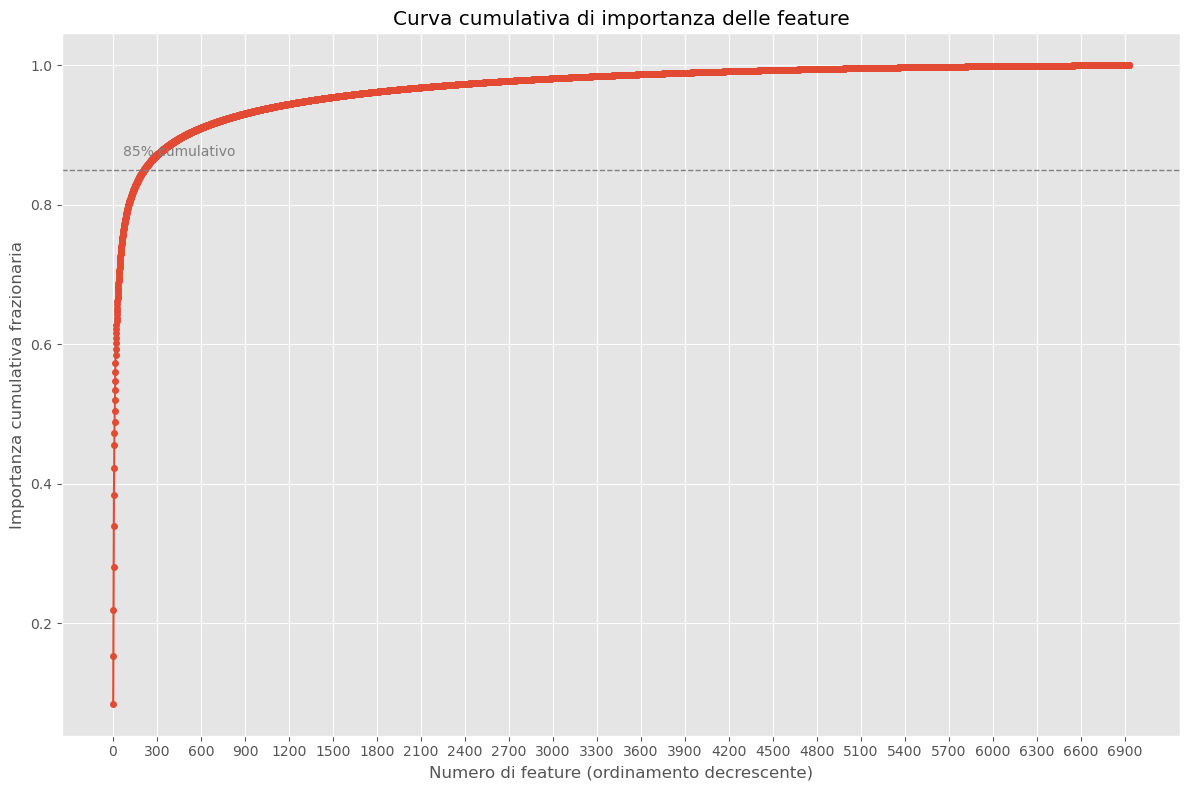

In [44]:
plt.figure(figsize=(12,8))
plt.plot(np.arange(1, len(fraction)+1), fraction.values, '-o', markersize=4)
plt.xlabel("Numero di feature (ordinamento decrescente)")
plt.ylabel("Importanza cumulativa frazionaria")
plt.title("Curva cumulativa di importanza delle feature")
plt.axhline(0.85, color='gray', linestyle='--', linewidth=1)
plt.xticks(np.arange(0, 7000, 300))
plt.text(len(fraction)*0.01, 0.87, "85% cumulativo", color='gray')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
selections_rf = []

# select genes up to 85%
for _, row in importances_df.iterrows():
    sorted_importance = row.sort_values(ascending=False)
    cumsum = sorted_importance.cumsum()
    selected = cumsum <= 0.85

    # riordinare mask
    mask = sorted_importance.index[selected].to_list()
    mask_boolean = [gene in mask for gene in importances_df.columns]
    selections_rf.append(mask_boolean)

#### Selezione dei geni

In [ ]:
# Calcolo la stability
selections_rf = np.array(selections_rf)
stability_scores_rf = np.mean(selections_rf, axis=0)

stable_threshold_rf = 0
stable_indices_rf  = np.where(stability_scores_rf >= stable_threshold_rf)[0]

if isinstance(X, pd.DataFrame):
    feature_names = X.columns.tolist()
    stable_features_rf = pd.DataFrame({
        'Feature_Index':stable_indices_rf,
        'Feature_Name':[feature_names[i] for i in stable_indices_rf],
        'Stability_Score': stability_scores_rf[stable_indices_rf]
    })
else:
    stable_features_rf = pd.DataFrame({
        'Feature_Index': stable_indices_rf,
        'Stability_Score': stability_scores_rf[stable_indices_rf]
    })

print("\nFeature stabili (RF):")
print(stable_features_rf.head())


Feature stabili (RF):
   Feature_Index     Feature_Name  Stability_Score
0              0  ENSG00000000003              0.0
1              1  ENSG00000000938              0.1
2              2  ENSG00000000971              0.0
3              3  ENSG00000001561              0.0
4              4  ENSG00000001617              0.0


In [ ]:
# stable_features_rf.to_csv("../date/result_all/rf_genes_stability_score.csv", index=False)

In [51]:
selected_genes_rf = stable_features_rf[
    stable_features_rf["Stability_Score"] >= 0.8
]["Feature_Name"].tolist()

X_selected_rf = X[selected_genes_rf]
print(f"\nNumero di geni selezionati con RF: {len(selected_genes_rf)}")


Numero di geni selezionati con RF: 94


In [52]:
for gene in selected_genes_rf:
    print(gene)

ENSG00000003147
ENSG00000011677
ENSG00000019505
ENSG00000019582
ENSG00000042062
ENSG00000064692
ENSG00000065809
ENSG00000073464
ENSG00000076344
ENSG00000079257
ENSG00000082512
ENSG00000086730
ENSG00000101049
ENSG00000102755
ENSG00000104081
ENSG00000105707
ENSG00000106484
ENSG00000106537
ENSG00000107816
ENSG00000112715
ENSG00000113580
ENSG00000114948
ENSG00000115183
ENSG00000118785
ENSG00000122591
ENSG00000124920
ENSG00000126890
ENSG00000130396
ENSG00000130475
ENSG00000130827
ENSG00000133808
ENSG00000134363
ENSG00000134569
ENSG00000135476
ENSG00000135842
ENSG00000137460
ENSG00000137486
ENSG00000137834
ENSG00000138646
ENSG00000139174
ENSG00000140968
ENSG00000143416
ENSG00000145604
ENSG00000148680
ENSG00000151090
ENSG00000151208
ENSG00000152778
ENSG00000153714
ENSG00000153898
ENSG00000154451
ENSG00000155324
ENSG00000157510
ENSG00000158023
ENSG00000158856
ENSG00000160325
ENSG00000161544
ENSG00000163132
ENSG00000165912
ENSG00000168118
ENSG00000168453
ENSG00000169184
ENSG00000169220
ENSG0000